In [438]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random

In [449]:
def load_data(path):
    # Your code here:
    loaded_data = pd.read_csv(path, parse_dates= ["date"])
    return loaded_data

In [546]:
def preprocess_data(data, normalize:bool=False, drop_sqft_living15:bool=False, test:bool=False):
    # Your code here:
    preprocessed_data = data.copy()  

    # add year, month and day columns in the data DF
    preprocessed_data["year"]  = preprocessed_data["date"].dt.year
    preprocessed_data["month"] = preprocessed_data["date"].dt.month
    preprocessed_data["day"]   = preprocessed_data["date"].dt.day

    # add a bias column of all 1's, drop the date column
    preprocessed_data.insert(0, "bias", 1)
    preprocessed_data.drop(["id", "date"], axis=1, inplace=True)

    # add age since renovated column accounting for houses not renovated since built
    age_since_renovated = np.zeros(len(preprocessed_data))
    for (i, value) in enumerate(preprocessed_data["yr_renovated"]):
        if value==0:
            age_since_renovated[i] = preprocessed_data["year"][i] - preprocessed_data["yr_built"][i]
        else:
            age_since_renovated[i] = preprocessed_data["year"][i] - preprocessed_data["yr_renovated"][i]
    preprocessed_data["age_since_renovated"] = age_since_renovated

    # normalize data if option to normalize selected
    if normalize:
        global params
        params = {}
        for col in preprocessed_data.columns:
            if col != "price" and col!= "waterfront" and col != "bias":
                μ = np.mean(preprocessed_data[col])
                σ = np.std(preprocessed_data[col])
                preprocessed_data[col]   = (preprocessed_data[col] -μ)/ σ
                params[col] = (μ, σ)
    if test:
         for col in preprocessed_data.columns:
            if col != "price" and col!= "waterfront" and col != "bias":
                μ = params[col][0]
                σ = params[col][1]
                preprocessed_data[col]   = (preprocessed_data[col] -μ)/ σ
                
    
    # drop sqrt living 15 if option selected to drop
    if drop_sqft_living15:
        preprocessed_data.drop(["sqft_living15"], axis=1, inplace=True)
    
    # return preprocessed data   
    return preprocessed_data


In [458]:
data = load_data('IA1_train.csv')
normalized_data = preprocess_data(data,normalize=True)

In [632]:
random.seed(2)
np.random.rand(data.shape[1])

array([0.16515335, 0.96289371, 0.5938621 , 0.45975024, 0.81757376,
       0.38018047, 0.79324314, 0.92588697, 0.87490593, 0.70114379,
       0.21822478, 0.59109443, 0.4024384 , 0.04556009, 0.71392265,
       0.36361365, 0.23857636, 0.57616453, 0.22599335, 0.61465803,
       0.936029  ])

In [668]:

a = np.random.rand(1, 21)

In [670]:
a[0]

array([4.37647315e-04, 6.94296679e-01, 5.86837033e-01, 8.69048223e-01,
       9.86009049e-01, 5.08674905e-01, 4.58455320e-01, 2.31985095e-01,
       8.81776342e-01, 6.88619185e-01, 6.65820067e-01, 1.66266540e-01,
       1.45760220e-01, 8.65103706e-01, 7.23653242e-01, 8.93281294e-01,
       4.20378079e-01, 3.23078652e-01, 4.31807056e-01, 3.16963242e-01,
       8.13516084e-01])

In [675]:
def gd_train(data, lr, ϵ, n_iter=4000):
    # Your code here:
    labels = data["price"].to_numpy()
    data = data.drop(["price"], axis=1)
    data = data.to_numpy()
    n_data = data.shape[0]
    n_features = data.shape[1]
    x = np.transpose(data)
    weights = np.ones(n_features)
    mse = np.zeros(n_iter + 1)   
    convergence = {}

     
    for i in range(n_iter):
        Bₙ = np.zeros(n_features)
        loss = 0
        for j in range(n_data):
            yᵢ = labels[j]
            xᵢ = x[:,j]
            ŷᵢ = np.dot(weights, xᵢ)
            Bₙ[:] += (ŷᵢ - yᵢ) * xᵢ          
            loss += (ŷᵢ - yᵢ) ** 2
        

        ΔL = (2/n_data) * Bₙ
        mse[i+1] = loss/n_data
        diff = mse[i+1] - mse[i]
        
        
        if abs(diff)<=ϵ and abs(diff) != mse[i+1]:
            weights -= lr * ΔL
            convergence[f"{lr}"] = True 
            return weights, mse[1: i+2], convergence
        
        elif diff < 0:
            weights -= lr * ΔL
            convergence[f"{lr}"] = "Will Converge"
            continue
        
        elif diff>0 and abs(diff) != mse[i+1]:
            convergence[f"{lr}"] = False
            return weights, mse[1: i+2], convergence
            
        weights -= lr * ΔL 
        
    return weights, mse[1: ], convergence

In [676]:
result = gd_train(normalized_data, 0.1, 10**-3)

In [677]:
weights, mse, convergence,  = result

In [9]:
def compare_rate(data, lrs, ϵ):
    mses = {}
    convergences = {}
    weights = {}
    for lr in lrs:
        (weight, mse, convergence) = gd_train(data, lr, ϵ)
        mses[f"{lr}"] = mse
        convergences[f"{lr}"] = convergence
        weights[f"{lr}"] = weight
        
    return weights, mses, convergences

In [10]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1]

In [506]:
weights, mses, convergence = compare_rate(normalized_data, lrs, 10 ** -3)

In [12]:
def plot_losses(losses, covergence):

    fig, ax = plt.subplots(figsize=[16,9])
    plt.ylabel('Loss', fontweight="bold", )
    plt.xlabel('Iteration', fontweight="bold")
#     plt.xlim(1, 4000)
    plt.title("Convergence of Learning steps; Normalized data", fontweight="bold")

    for (γ, loss) in losses.items():
        
        if convergence[γ][γ]==False:
            pass
        else:
            iterations = [j for j in range(1, len(loss)+1)]
            plt.plot(iterations, loss, label=f"γ={γ}")
            
    ax.legend(loc='upper right')
    plt.savefig("Convergence")
    plt.show()

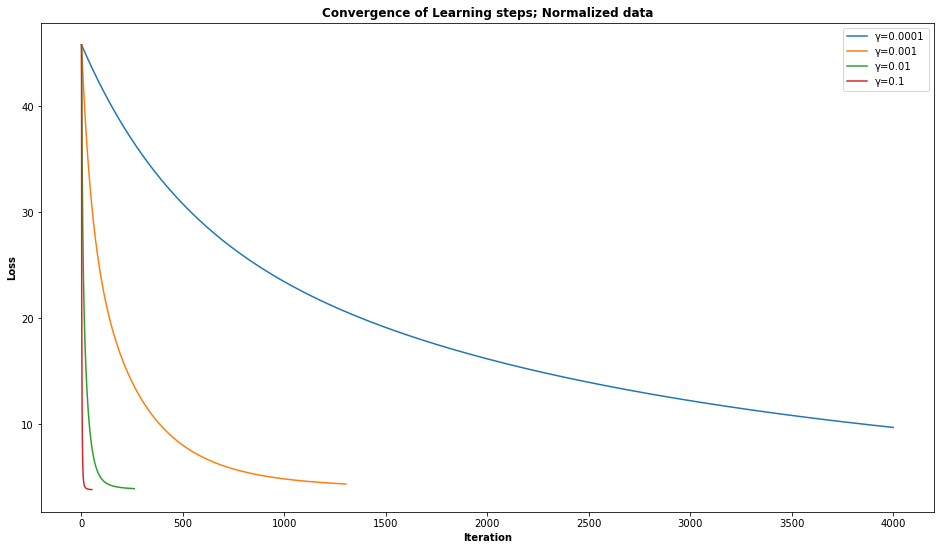

In [13]:
plot_losses(mses, convergence)

In [14]:
val_data = load_data("IA1_dev.csv")

In [531]:
def validate(val_data, weights):
    val_labels = val_data["price"].to_numpy()
    val_data = val_data.drop(["price"], axis=1)
    val_data = val_data.to_numpy()
    n_data = val_data.shape[0]
    x_val = np.transpose(val_data)
     
    mse = {}
    if type(weights) is dict:
        for (γ, weight) in weights.items():
            loss = 0
            if convergence[γ][γ]==False:
                pass
            else:
                for j in range(n_data):
                    yᵢ_val = val_labels[j]
                    xᵢ_val = x_val[:,j]
                    ŷᵢ_val = np.dot(weight, xᵢ_val)         
                    loss += (ŷᵢ_val - yᵢ_val) ** 2
                mse[f"{γ}"] = round((1/n_data) * loss, 3) 
    else:
        loss=0
        for j in range(n_data):
                yᵢ_val = val_labels[j]
                xᵢ_val = x_val[:,j]
                ŷᵢ_val = np.dot(weights, xᵢ_val)         
                loss += (ŷᵢ_val - yᵢ_val) ** 2
        mse = round((1/n_data) * loss, 3)
        return mse
    
    return mse

In [543]:
val_data = load_data("IA1_dev.csv")
val_preprocessed = preprocess_data(val_data, test=True)

In [545]:
validate(val_preprocessed, weights)

{'0.0001': 10.918, '0.001': 5.265, '0.01': 4.792, '0.1': 4.704}

In [528]:
data
plain_data =preprocess_data(data)

In [740]:
plain_result = gd_train(plain_data, lr = 9.84*(10**-11), ϵ=0.01, n_iter = 4000)

In [741]:
plain_result

(array([ 9.99989124e-01,  9.99423805e-01,  9.99406577e-01,  7.50961432e-02,
        -7.18507373e-04,  9.99810108e-01,  9.99993038e-01,  9.99746629e-01,
         1.00001161e+00,  9.99011905e-01,  2.89282052e-01,  7.85814092e-01,
         9.71361082e-01,  8.77846815e-01, -5.69099644e-02,  9.99473086e-01,
         1.00129926e+00,  3.87766582e-01, -2.89349848e-03,  9.78109928e-01,
         9.99885009e-01,  9.99885718e-01,  1.01016137e+00]),
 array([2.31182265e+10, 2.12153585e+10, 2.05245812e+10, ...,
        5.58747252e+05, 5.58490708e+05, 5.58234325e+05]),
 {'9.839999999999999e-11': 'Will Converge'})

In [742]:
plain_weight = plain_result[0]

In [743]:
val_plain = preprocess_data(val_data)

In [744]:
validate(val_plain, plain_weight)

552201.588

In [750]:
plain_weight[1:]

array([ 9.99423805e-01,  9.99406577e-01,  7.50961432e-02, -7.18507373e-04,
        9.99810108e-01,  9.99993038e-01,  9.99746629e-01,  1.00001161e+00,
        9.99011905e-01,  2.89282052e-01,  7.85814092e-01,  9.71361082e-01,
        8.77846815e-01, -5.69099644e-02,  9.99473086e-01,  1.00129926e+00,
        3.87766582e-01, -2.89349848e-03,  9.78109928e-01,  9.99885009e-01,
        9.99885718e-01,  1.01016137e+00])

In [461]:
data_sqrt_living_dropped = preprocess_data(data, normalize =True, drop_sqft_living15=True)

In [537]:
data_sqrt_living_dropped_result = gd_train(data_sqrt_living_dropped, 0.1, 10**-3)

In [538]:
data_sqrt_living_dropped_weights = data_sqrt_living_dropped_result[0]

In [551]:
data_sqrt_living_dropped_weights[1:]

array([-0.27722643,  0.3293128 ,  0.59866203,  0.05009236,  0.04262883,
        1.17317547,  0.54360895,  0.19409438,  1.17722584,  0.94945274,
        0.25747382,  0.52274426,  0.55832287, -0.25360272,  0.83304651,
       -0.26174167, -0.09483023,  0.26910221,  0.1790998 , -0.03572605,
        1.31155977])

In [549]:
dropped_sqft_living_val = preprocess_data(val_data, drop_sqft_living15 = True, test = True)

In [550]:
validate(dropped_sqft_living_val, data_sqrt_living_dropped_weights)

4.726